In [1]:
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(49)

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

In [5]:
dataset_ex_df = pd.read_csv('csv/TSLA.csv', header=0, parse_dates=[0], date_parser=parser)

In [6]:
dataset_ex_df.head()

,Date,TSLA
0,2010-06-30,4.766
1,2010-07-01,4.392
2,2010-07-02,3.840
3,2010-07-06,3.222
4,2010-07-07,3.160


In [7]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2393 number of days in the dataset.


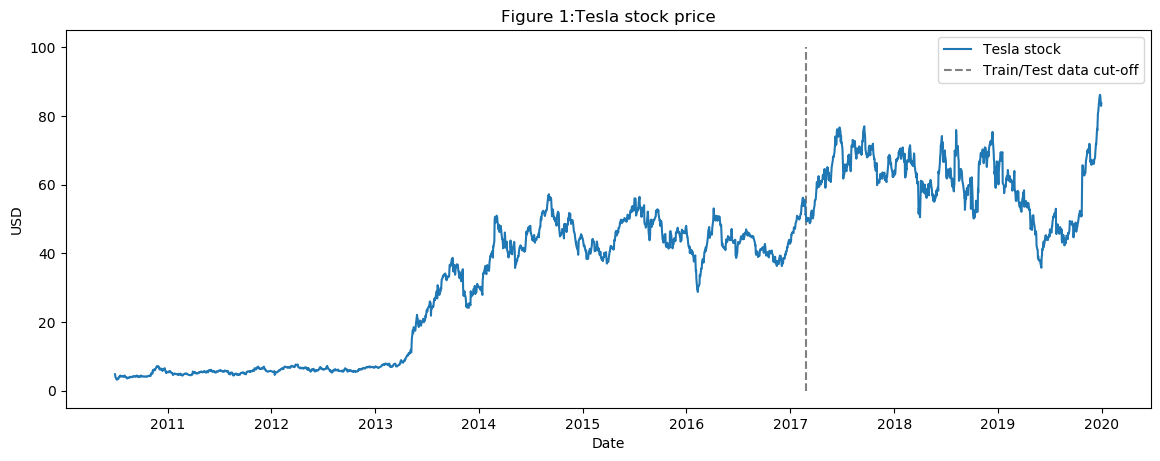

In [8]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['TSLA'], label='Tesla stock')
plt.vlines(datetime.date(2017,2, 24), 0, 100, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1:Tesla stock price')
plt.legend()
plt.show()

In [9]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1675. Number of test days: 718.


In [10]:
correlated_assets = ['F', 'FCAU', 'GM', 'HMC', 'HYMTF', 'NSANY', 'PUGOY', 'RNOPA', 'TM', 'VOW3DE']

In [11]:
for i in correlated_assets:
    dataset_tmpr = pd.read_csv('csv/'+str(i)+'.csv', header=0, parse_dates=[0], date_parser=parser)
    dataset_tmpr = dataset_tmpr[(dataset_tmpr['Date'] > '2010-06-29') & (dataset_tmpr['Date'] < '2020-01-01')]
    
    dataset_tmpr = dataset_tmpr.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1).reset_index(drop = True)
    dataset_tmpr.columns = ['Date', i]
    dataset_ex_df = dataset_ex_df.merge(dataset_tmpr, how = 'left', on = 'Date')    
    

In [12]:
dataset_ex_df

,Date,TSLA,F,FCAU,GM,HMC,HYMTF,NSANY,PUGOY,RNOPA,TM,VOW3DE
0,2010-06-30,4.766000,10.08,3.226447,NaN,28.750000,21.250000,13.86,25.650000,30.785000,68.570000,72.379997
1,2010-07-01,4.392000,10.57,3.226447,NaN,28.799999,19.799999,13.72,25.340000,29.559999,68.699997,69.970001
2,2010-07-02,3.840000,10.28,3.226447,NaN,28.590000,19.799999,13.76,26.100000,30.170000,68.260002,70.070000
3,2010-07-06,3.222000,10.16,3.226447,NaN,29.190001,19.799999,14.62,26.100000,31.125000,70.029999,71.379997
4,2010-07-07,3.160000,10.59,3.226447,NaN,29.459999,19.400000,14.62,28.150000,32.145000,71.000000,71.239998
...,...,...,...,...,...,...,...,...,...,...,...,...
2388,2019-12-24,85.050003,9.47,14.790000,36.580002,28.660000,31.500000,11.87,24.030001,43.235001,141.339996,NaN
2389,2019-12-26,86.188004,9.45,14.840000,36.480000,28.760000,31.500000,11.59,24.020000,NaN,141.529999,NaN
2390,2019-12-27,86.075996,9.36,14.870000,36.560001,28.580000,31.500000,11.59,24.290001,43.000000,141.279999,176.660004
2391,2019-12-30,82.940002,9.25,14.690000,36.439999,28.270000,31.500000,11.54,23.930000,42.599998,140.610001,176.240005


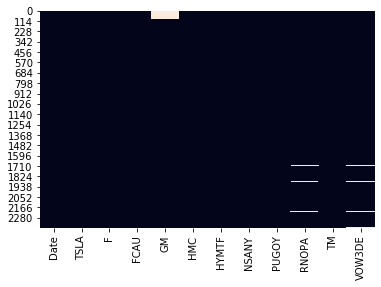

In [13]:
sns.heatmap(dataset_ex_df.isnull(), cbar=False)

In [16]:
dataset_ex_df = dataset_ex_df.fillna(method = 'ffill')
#last resort
dataset_ex_df = dataset_ex_df.fillna(method = 'backfill')

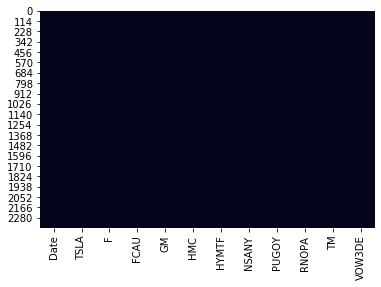

In [17]:
sns.heatmap(dataset_ex_df.isnull(), cbar=False)

In [19]:
dataset_ex_df

,Date,TSLA,F,FCAU,GM,HMC,HYMTF,NSANY,PUGOY,RNOPA,TM,VOW3DE
0,2010-06-30,4.766000,10.08,3.226447,34.189999,28.750000,21.250000,13.86,25.650000,30.785000,68.570000,72.379997
1,2010-07-01,4.392000,10.57,3.226447,34.189999,28.799999,19.799999,13.72,25.340000,29.559999,68.699997,69.970001
2,2010-07-02,3.840000,10.28,3.226447,34.189999,28.590000,19.799999,13.76,26.100000,30.170000,68.260002,70.070000
3,2010-07-06,3.222000,10.16,3.226447,34.189999,29.190001,19.799999,14.62,26.100000,31.125000,70.029999,71.379997
4,2010-07-07,3.160000,10.59,3.226447,34.189999,29.459999,19.400000,14.62,28.150000,32.145000,71.000000,71.239998
...,...,...,...,...,...,...,...,...,...,...,...,...
2388,2019-12-24,85.050003,9.47,14.790000,36.580002,28.660000,31.500000,11.87,24.030001,43.235001,141.339996,176.160004
2389,2019-12-26,86.188004,9.45,14.840000,36.480000,28.760000,31.500000,11.59,24.020000,43.235001,141.529999,176.160004
2390,2019-12-27,86.075996,9.36,14.870000,36.560001,28.580000,31.500000,11.59,24.290001,43.000000,141.279999,176.660004
2391,2019-12-30,82.940002,9.25,14.690000,36.439999,28.270000,31.500000,11.54,23.930000,42.599998,140.610001,176.240005
